In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skimage.feature import hog
import cv2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import seaborn as sns
import shap

In [15]:
DATASET_PATH = r"D:\Download\archive\seg_train\seg_train"

In [12]:
img = cv2.imread(r"D:\Download\archive\seg_test\seg_test\buildings\20061.jpg")
print(np.min(img), np.max(img))

0 255


In [ ]:
def load_dataset(dataset_path, img_size=(64, 64)):
    images = []
    labels = []
    
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue
        
        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(category)
    
    return np.array(images), np.array(labels)

In [16]:
X, y = load_dataset(DATASET_PATH)

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [18]:
def extract_features(images):
    feature_list = []
    
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), feature_vector=True)
        feature_list.append(hog_features)
    
    return np.array(feature_list)

In [19]:
X_features = extract_features(X)

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

In [21]:
def plot_sample_images(X, y, label_encoder, num_samples=10):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {label_encoder.inverse_transform([y[idx]])[0]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [22]:
def plot_hog_feature(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(hog_image, cmap="gray")
    ax[1].set_title("HOG Features")
    ax[1].axis("off")
    
    plt.show()

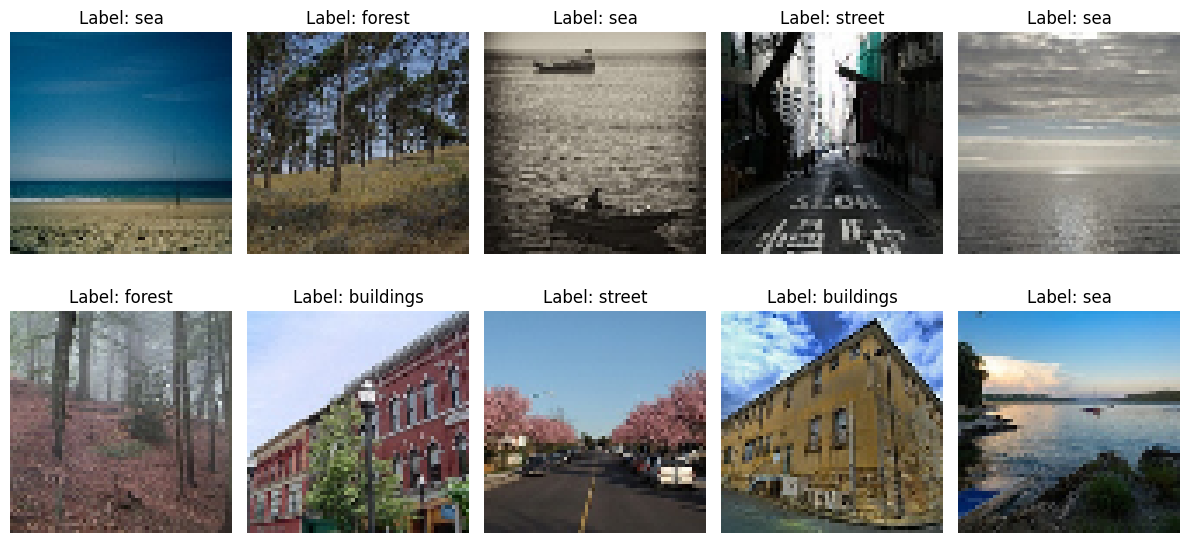

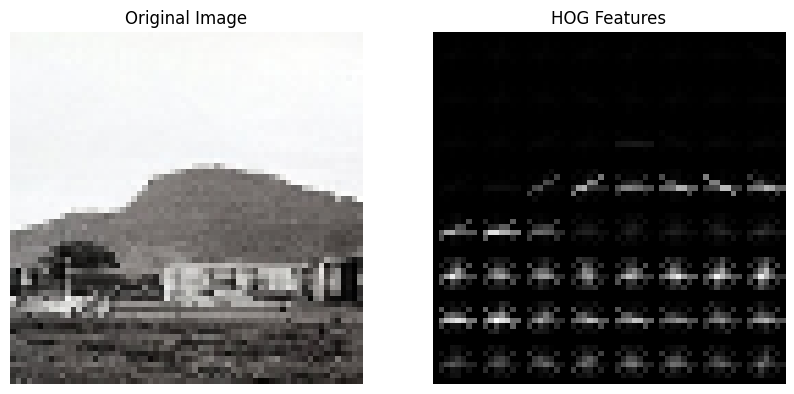

In [27]:
plot_sample_images(X, y_encoded, label_encoder, num_samples=10)
plot_hog_feature(X[0])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [30]:
param_grid = {
    'n_estimators': [100,300],
    'learning_rate': [0.01, 0.1],
    'max_depth' : [12, 20],
    'gamma' : [0,1,5],
    'colsample_bytree': [0.5, 1.0],
    'min_child_weight':[3,5]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42),
param_grid=param_grid,
scoring='accuracy',
cv=5,
n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print(y_pred)

In [ ]:
proba = best_model.predict_proba(X_test)
print(proba)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

In [ ]:
y_prob = best_model.predict_proba(X_test)

roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(roc_auc_ovr)

y_test_bin = label_binarize(y_test, classes = best_model.classes_)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [ ]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_prob[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 
                                   'Importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)

In [ ]:
def predict_new_image(image_path, model, label_encoder, scaler, img_size=(64, 64)):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, img_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)
    
    hog_features_scaled = scaler.transform([hog_features])
    
    pred_label_encoded = model.predict(hog_features_scaled)[0]
    predicted_label = label_encoder.inverse_transform([pred_label_encoded])[0]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    
    return predicted_label

In [ ]:
image_path = "path_ke_gambar_baru.jpg"
predicted_class = predict_new_image(image_path, model, label_encoder, scaler)
print(f"Hasil Prediksi: {predicted_class}")